In [1]:
# !python -V
# !pip install fastparquet
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pickle

from sklearn.feature_extraction import DictVectorizer

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge

from sklearn.metrics import root_mean_squared_error

# !pwd
df1 = pd.read_parquet('../notebooks/data/green_tripdata_2021-01.parquet')
df2 = pd.read_parquet('../notebooks/data/green_tripdata_2021-02.parquet')
df1['data'] = "train"
df2['data'] = "test"
df = pd.concat([df1, df2])
del df1
del df2
# df

In [2]:
# print(df.dtypes)
df = df[df.trip_type == 1]
# unnecessary with parquet files:
# df.lpep_dropoff_datetime = pd.to_datetime(df.lpep_dropoff_datetime)
# df.lpep_pickup_datetime = pd.to_datetime(df.lpep_pickup_datetime)


In [3]:
df['duration'] = df.lpep_dropoff_datetime - df.lpep_pickup_datetime
df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)
# df

In [4]:
# sns.displot(df.duration)

In [5]:
df.duration.describe(percentiles = [0.2,0.95, 0.98, 0.99])

count    73605.000000
mean        19.562436
std         75.031665
min          0.000000
20%          5.883333
50%         11.100000
95%         45.430000
98%         64.700000
99%         81.998667
max       1439.616667
Name: duration, dtype: float64

In [6]:
print(((df.duration >= 1) & (df.duration < 60)).mean())
df = df[(df.duration >= 1) & (df.duration < 60)]
# df

0.9545954758508254


In [7]:
categorical = ['PULocationID', 'DOLocationID']
numerical = ['trip_distance']

In [8]:
print(df[categorical].dtypes)
df[categorical].astype(str).dtypes


PULocationID    int64
DOLocationID    int64
dtype: object


PULocationID    object
DOLocationID    object
dtype: object

In [9]:
df[numerical].dtypes

trip_distance    float64
dtype: object

In [10]:
df[categorical] = df[categorical].astype(str)


In [11]:
# split training from tesing data
dtr = df[df['data'].str.contains('train')]
dte = df[df['data'].str.contains('test')]


In [12]:
# df[categorical + numerical].iloc[:10].to_dict(orient='records')
train_dict = dtr[categorical + numerical].to_dict(orient='records')
test_dict  = dte[categorical + numerical].to_dict(orient='records')

In [13]:
dv = DictVectorizer()
X_train = dv.fit_transform(train_dict)
X_test  = dv.transform(test_dict)

In [14]:
# dv.feature_names_

In [15]:
X_train
# X_test

<37535x464 sparse matrix of type '<class 'numpy.float64'>'
	with 112605 stored elements in Compressed Sparse Row format>

In [16]:
target = 'duration'
y_train = dtr[target].values
y_test  = dte[target].values


In [17]:
y_train
y_test

array([17.91666667,  6.5       , 15.25      , ...,  5.41666667,
       10.01666667,  5.6       ])

In [18]:
lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression()

In [19]:
y_pred = lr.predict(X_train)

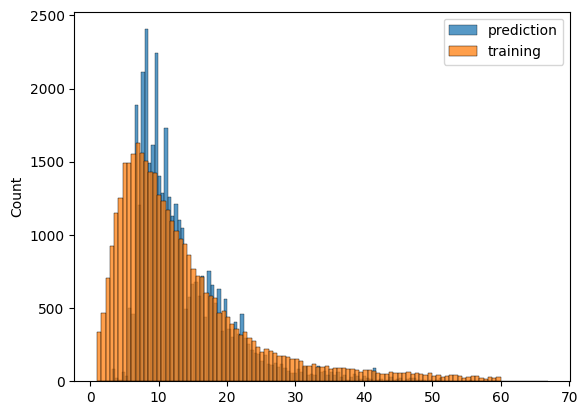

In [20]:
sns.histplot(y_pred, label = 'prediction')
sns.histplot(y_train, label = 'training')

plt.legend()

In [21]:
root_mean_squared_error(y_train, y_pred)
### model is wrong by 7.87 minutes on average

7.528858918918764

In [22]:
# la = Lasso()
# la.fit(X_train, y_train)

In [23]:
# y_pred_la = la.predict(X_train)
# sns.histplot(y_pred_la, label = 'prediction')
# sns.histplot(y_train, label = 'training')

# plt.legend()

In [24]:
# root_mean_squared_error(y_train, y_pred_la)
### lasso model is wrong by 10.4 minutes on average

> From here on script is function based (following video at approx. 29:00)

In [25]:
#### capture all in a function
def read_dataframe(path_to_file):
    DF = pd.read_parquet(path_to_file)

    DF = DF[DF.trip_type == 1]
    
    DF['duration'] = DF.lpep_dropoff_datetime - DF.lpep_pickup_datetime
    DF.duration = DF.duration.apply(lambda td: td.total_seconds() / 60)

    DF = DF[(DF.duration >= 1) & (DF.duration < 60)]
    
    categorical = ['PULocationID', 'DOLocationID']
    DF[categorical] = DF[categorical].astype(str)
    DF['PUDO'] = DF['PULocationID'] + '_' + DF['DOLocationID']
    categorical = ['PUDO']

    DF[categorical] = DF[categorical].astype(str)
    numerical = ['trip_distance']
    return DF


In [26]:
df_train = read_dataframe('../notebooks/data/green_tripdata_2021-01.parquet')
df_test = read_dataframe('../notebooks/data/green_tripdata_2021-02.parquet')

In [27]:
len(dtr), len(dte), len(df_train), len(df_test)

(37535, 32728, 37535, 32728)

In [28]:
# df[categorical + numerical].iloc[:10].to_dict(orient='records')
train_dict = df_train[categorical + numerical].to_dict(orient='records')
test_dict  =  df_test[categorical + numerical].to_dict(orient='records')

dv = DictVectorizer()
X_train = dv.fit_transform(train_dict)
X_test  = dv.transform(test_dict) #### AND NOT fit_transform

target = 'duration'
y_train = df_train[target].values
y_test  =  df_test[target].values

8.418751864502658

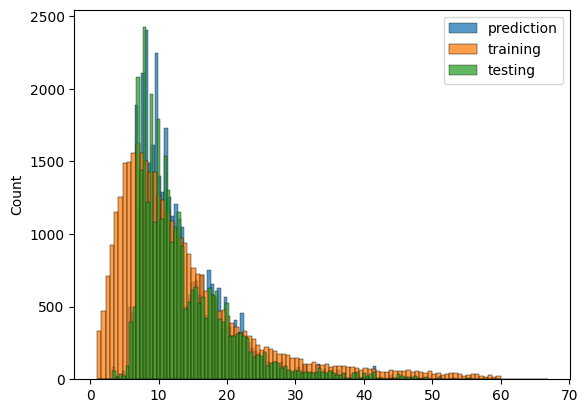

In [29]:
lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred_lr = lr.predict(X_train)
y_pred_lr_test = lr.predict(X_test)

sns.histplot(y_pred_lr, label = 'prediction')
sns.histplot(y_train, label = 'training')
sns.histplot(y_pred_lr_test, label = 'testing')
plt.legend()
root_mean_squared_error(y_train, y_pred_lr)
root_mean_squared_error(y_test, y_pred_lr_test)

In [30]:
# la = Lasso()
# la.fit(X_train, y_train)

# y_pred_la = la.predict(X_train)
# y_pred_la_test = la.predict(X_test)
# sns.histplot(y_pred_la, label = 'prediction')
# sns.histplot(y_train, label = 'training')
# sns.histplot(y_pred_la_test, label = 'testing')
# plt.legend()
# root_mean_squared_error(y_train, y_pred_la)
# root_mean_squared_error(y_test, y_pred_la_test)

In [31]:
# la = Lasso(alpha = 0.01)
# la.fit(X_train, y_train)

# y_pred_la_test = la.predict(X_test)
# sns.histplot(y_pred_la, label = 'prediction')
# sns.histplot(y_train, label = 'training')
# sns.histplot(y_pred_la_test, label = 'testing')
# plt.legend()
# root_mean_squared_error(y_test, y_pred_la_test)

In [32]:
lr

LinearRegression()

In [33]:
dv

DictVectorizer()

In [36]:
!pwd

/workspaces/mlops-zc/01-intro


In [38]:
with open('../notebooks/models/lr.bin', 'wb') as f_out:
    pickle.dump((lr, dv), f_out)